# Protein Synthesis Simulation

Load dataset:

In [1]:
from HumanGenomeDataset.load_dataset import load_dataset

data_df = load_dataset('dna_protein_coding_sequences')
data_df.head(2)

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,ID,sequence,category
0,NM_001368254.1,GCTGAGCTGAGCTGGGGCGCAGCCGCCTGTCTGCACCGGCAGCACC...,NM
1,NM_001350977.1,TCCACAACTGAAACATCCACTTCTGAACACCATGTCCTACTACAGC...,NM


### Simulation

In [2]:
from src.simulation import ProteinSinthesisProcess

In [3]:
import random
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Simulation parameters
SIM_TIME = 3600*5 # 5 hours
NUMBER_RESOURCES = 205
NUMBER_RNA_POLYMERASES = 103
NUMBER_RIBOSOMES = 37
NUMBER_RNA_TRANSFER = 1700
URACIL_INITIAL_AMOUNT = random.randint(5e+4, 8e+4)
ADENINE_INITIAL_AMOUNT = random.randint(8e+4, 1e+5)
GUANINE_INITIAL_AMOUNT = random.randint(5e+4, 8e+4)
CYTOSINE_INITIAL_AMOUNT = random.randint(5e+4, 8e+4)

In [4]:
protein_synthesis_process = ProteinSinthesisProcess(
    dna_sequences_df=data_df,
    number_resources=NUMBER_RESOURCES,
    number_rna_polymerases=NUMBER_RNA_POLYMERASES, 
    number_ribosomes=NUMBER_RIBOSOMES,
    number_rna_transfers_per_codon=NUMBER_RNA_TRANSFER,
    uracil_initial_amount=URACIL_INITIAL_AMOUNT,
    adenine_initial_amount=ADENINE_INITIAL_AMOUNT,
    guanine_initial_amount=GUANINE_INITIAL_AMOUNT,
    cytosine_initial_amount=CYTOSINE_INITIAL_AMOUNT,
    random_seed=RANDOM_SEED,
    verbose=False
    )

Simulation environment initialized, time unit: 0.0001 second.


In [5]:
print(protein_synthesis_process)

Protein Sinthesis Process:
185310 dna sequences to synthesize,
105 resources available,
43 RNA polymerases,
12 ribosomes,
33648 uracil bases,
40819 adenine bases,
39012 guanine bases,
38024 cytosine bases,
748 transfer RNA for UUU codon,
726 transfer RNA for UCU codon,
790 transfer RNA for UAU codon,
782 transfer RNA for UGU codon,
777 transfer RNA for UUC codon,
755 transfer RNA for UCC codon,
746 transfer RNA for UAC codon,
859 transfer RNA for UGC codon,
742 transfer RNA for UUA codon,
871 transfer RNA for UCA codon,
828 transfer RNA for UAA codon,
728 transfer RNA for UGA codon,
727 transfer RNA for UUG codon,
743 transfer RNA for UCG codon,
775 transfer RNA for UAG codon,
779 transfer RNA for UGG codon,
849 transfer RNA for CUU codon,
874 transfer RNA for CCU codon,
726 transfer RNA for CAU codon,
863 transfer RNA for CGU codon,
770 transfer RNA for CUC codon,
859 transfer RNA for CCC codon,
827 transfer RNA for CAC codon,
776 transfer RNA for CGC codon,
834 transfer RNA for CUA c

In [ ]:
print(repr(protein_synthesis_process))

Start simulation:

In [6]:
protein_synthesis_process.run(simulation_time=SIM_TIME) # run the simulation

Simulation started
259 molecules
242 molecules
234 molecules
252 molecules
239 molecules
242 molecules
257 molecules
251 molecules
268 molecules
257 molecules
230 molecules
258 molecules
232 molecules
260 molecules
238 molecules
237 molecules
237 molecules
238 molecules
268 molecules
231 molecules
246 molecules
246 molecules
266 molecules
260 molecules
247 molecules
255 molecules
260 molecules
234 molecules
245 molecules
233 molecules
250 molecules
251 molecules
264 molecules
254 molecules
242 molecules
247 molecules
234 molecules
230 molecules
235 molecules
250 molecules
260 molecules
230 molecules
263 molecules
257 molecules
233 molecules
248 molecules
238 molecules
238 molecules
265 molecules
257 molecules
266 molecules
265 molecules
254 molecules
254 molecules
244 molecules
246 molecules
259 molecules
234 molecules
253 molecules
268 molecules
241 molecules
237 molecules
244 molecules
270 molecules
270 molecules
236 molecules
232 molecules
231 molecules
239 molecules
251 molecules
2

In [7]:
protein_synthesis_process.save_process(folder_test_name='test') # save the process

Process saved.


### Results

In [8]:
import pandas as pd
results_path = 'results/test/results.csv'

results_df = pd.read_csv(results_path, index_col=0)

In [9]:
print('Number of DNA sequence traslated:', results_df[results_df['mrna_sequences'].notna()].shape[0])
print('Number of DNA sequence not traslated:', results_df[results_df['protein_synthesized']==False].shape[0])

Number of DNA sequence traslated: 191
Number of DNA sequence not traslated: 11


In [10]:
results_df[results_df['mrna_sequences'].notna()][[
    'polypeptides_chains', 'number_of_proteins_synthesized', 'length_proteins', 'number_different_proteins']]

,polypeptides_chains,number_of_proteins_synthesized,length_proteins,number_different_proteins
6677,['NH2-LDGGTRPGPTEESERRNDSHRRAPRKRWCVTQQCLLPF-C...,1,[38],1.0
6811,['NH2-L-COOH'],1,[1],1.0
6954,['NH2-SRRDLGRMWWDLKLLHVHNCYPLLCRGSLPWLELRGLSDP...,1,[46],1.0
9405,"['NH2-TYRKRNHLLPGKNFGSRDVRRTD-COOH', 'NH2-TYRK...",2,"[23, 23]",1.0
9749,['NH2-FKSRKTSKGSRGVLIAFPRYHSVGGPGHNSPYLYDDYSPR...,3,"[69, 69, 69]",1.0
...,...,...,...,...
179426,['NH2-SKSSR-COOH'],1,[5],1.0
180417,"['NH2-TGGSRTV-COOH', 'NH2-TGGSRTV-COOH', 'NH2-...",3,"[7, 7, 7]",1.0
182761,"['NH2-CWTPSP-COOH', 'NH2-CWTPSP-COOH']",2,"[6, 6]",1.0
183159,['NH2-STGPARHVQ-COOH'],1,[9],1.0


In [11]:
results_df[results_df['mrna_sequences'].notna()][
    ['request_start_process_time', 'start_process_time', 'end_process_time',
    'number_different_proteins', 'number_of_proteins_synthesized']
    ].describe()

,request_start_process_time,start_process_time,end_process_time,number_different_proteins,number_of_proteins_synthesized
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,4997.691006,4997.691006,5293.068645,1.130890,2.277487
std,3090.031602,3090.031602,3043.218776,0.501197,1.573286
min,0.000000,0.000000,143.787900,0.000000,1.000000
25%,2222.310100,2222.310100,2668.359750,1.000000,1.000000
50%,4889.079400,4889.079400,5162.448300,1.000000,2.000000
75%,7546.545900,7546.545900,7926.376250,1.000000,3.000000
max,10548.240300,10548.240300,10655.151400,3.000000,10.000000


In [12]:
"""
statistiche su: (sono liste di valori)
'start_transcription_time', 'start_translation_time',
'end_translation_time', 'length_proteins', 'protein_synthesized'
"""

"\nstatistiche su: (sono liste di valori)\n'start_transcription_time', 'start_translation_time',\n'end_translation_time', 'length_proteins', 'protein_synthesized'\n"

### Protein Length

In [13]:
from src.utils.plot_utils import *

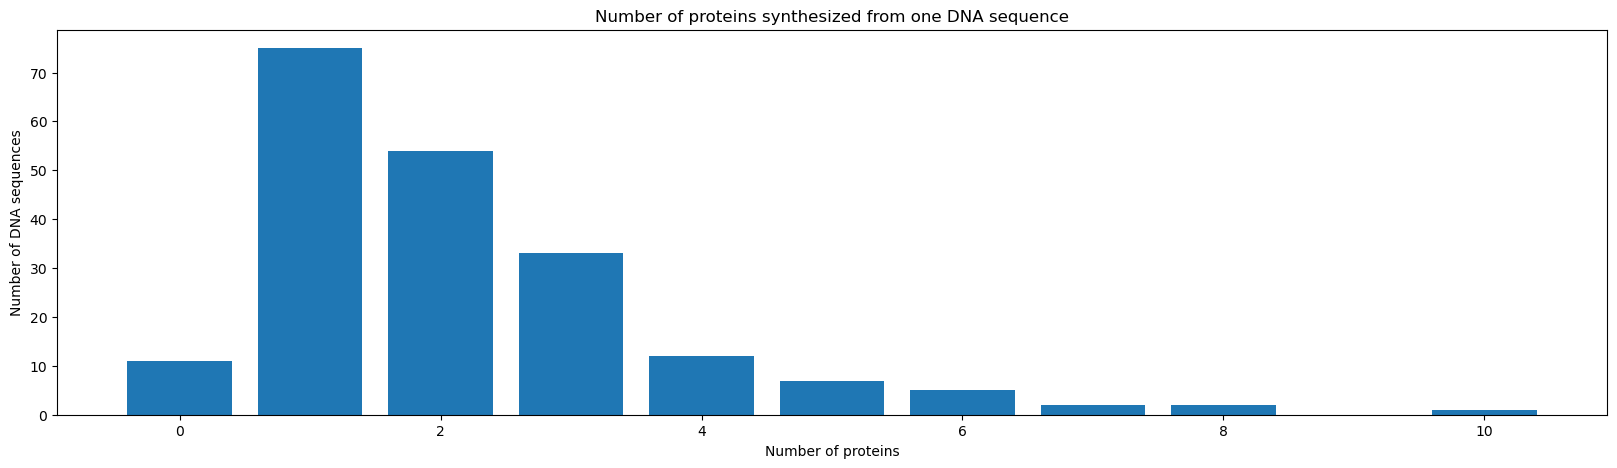

In [14]:
barplot_proteins_number(results_df)

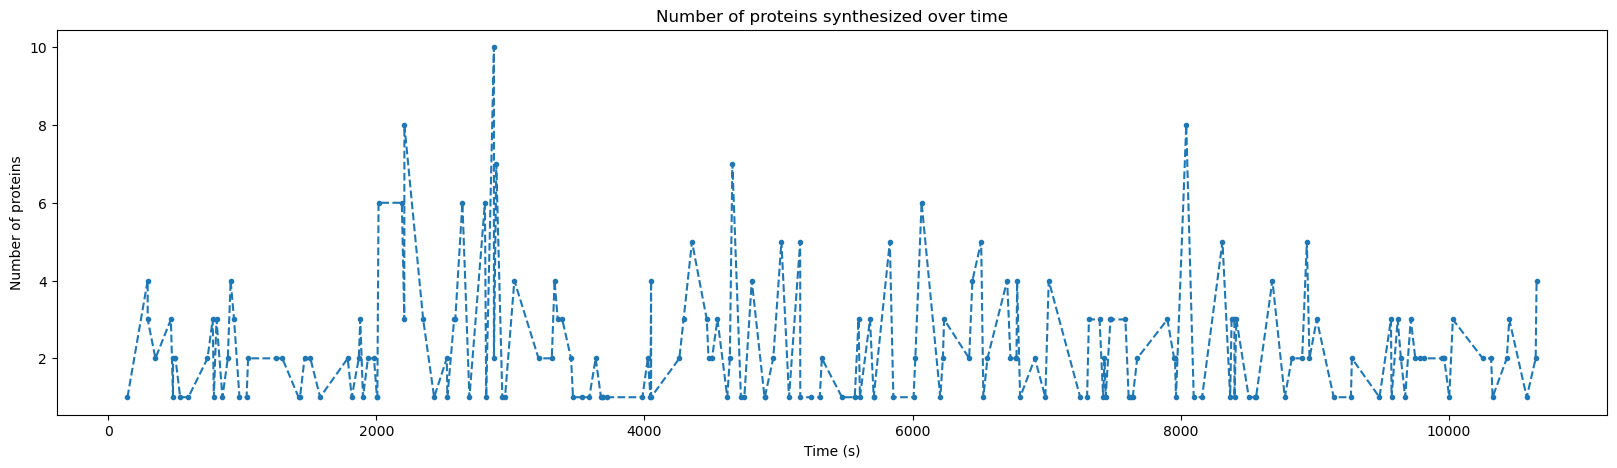

In [15]:
plot_proteins_number_over_time(results_df)

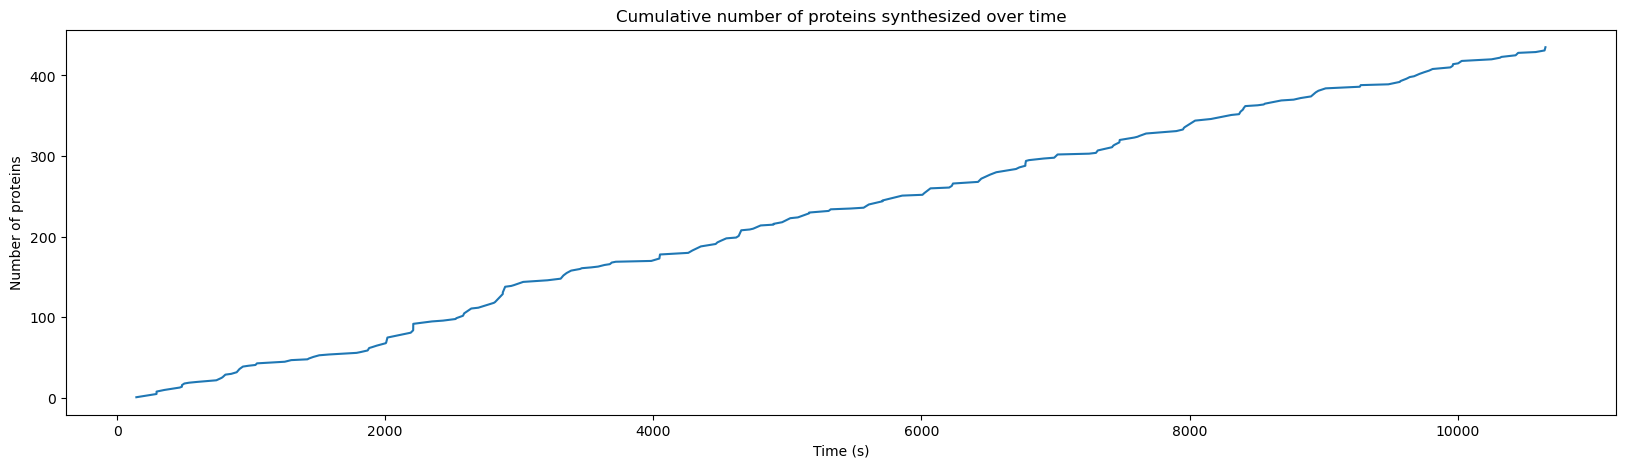

In [16]:
plot_cumulative_proteins_number_over_time(results_df)

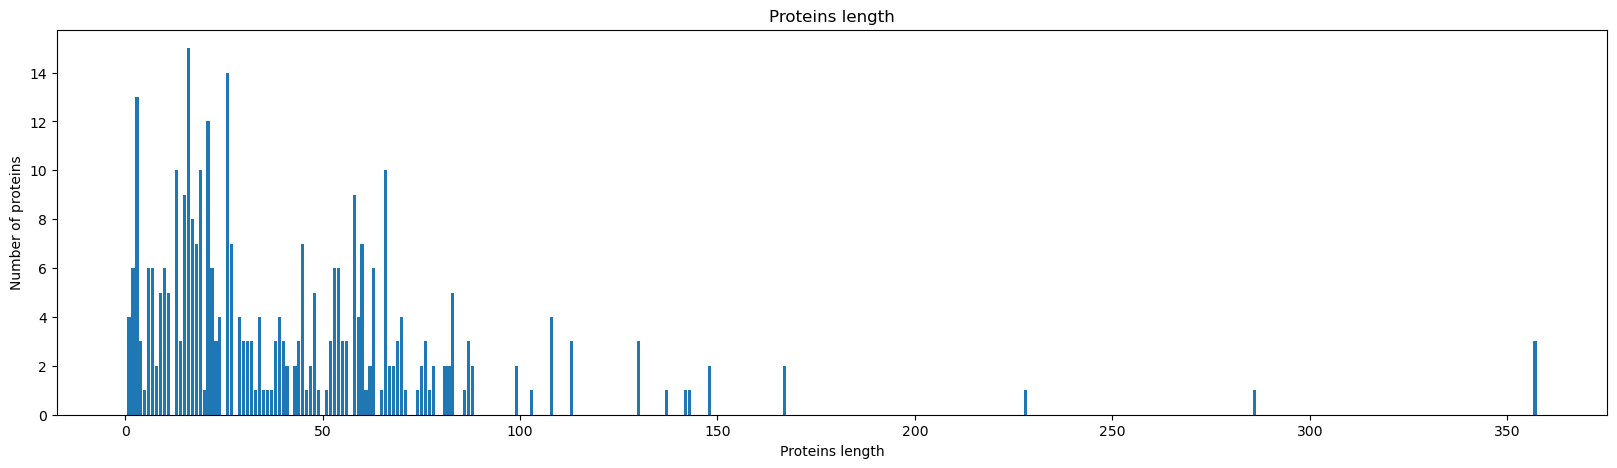

In [17]:
barplot_proteins_length(results_df)

### Nucleotides Level

In [18]:
import json

with open('results/test/nucleotides/nucleotides_history_uracil.json') as f:
    uracil_dict = json.load(f)

with open('results/test/nucleotides/nucleotides_history_adenine.json') as f:
    adenine_dict = json.load(f)

with open('results/test/nucleotides/nucleotides_history_guanine.json') as f:
    guanine_dict = json.load(f)

with open('results/test/nucleotides/nucleotides_history_cytosine.json') as f:
    cytosine_dict = json.load(f)

In [19]:
plot_nucleotide_level_over_time(uracil_dict, adenine_dict, guanine_dict, cytosine_dict, time_unit=1)

### RNA Polymerase

In [ ]:
with open('results/test/rna_polymerase_history.json') as f:
    rna_polymerase_dict = json.load(f)

In [ ]:
rna_polymerase_df = dict_to_dataframe(rna_polymerase_dict)

In [ ]:
rna_polymerase_df.describe() # values in seconds

,queue,request_time,available_time,wait_time,end_time,usage_time
count,123.0,123.000000,123.000000,123.0,123.000000,123.000000
mean,0.0,1489.154038,1489.154038,0.0,1617.364306,21.486432
std,0.0,875.209717,875.209717,0.0,894.483069,19.441096
min,0.0,0.000000,0.000000,0.0,92.143100,0.253800
25%,0.0,738.352950,738.352950,0.0,911.936700,6.530150
50%,0.0,1461.936600,1461.936600,0.0,1615.952300,16.111400
75%,0.0,2268.166750,2268.166750,0.0,2370.246900,32.599300
max,0.0,2944.667400,2944.667400,0.0,3234.902400,85.485200


### Ribosome

In [ ]:
with open('results/test/ribosome_history.json') as f:
    ribosome_dict = json.load(f)

In [ ]:
ribosome_df = dict_to_dataframe(ribosome_dict)

In [ ]:
ribosome_df.describe()

,queue,request_time,available_time,wait_time,end_time,usage_time
count,123.0,123.000000,123.000000,123.0,123.000000,123.000000
mean,0.0,1617.364306,1617.364306,0.0,1631.853615,11.613076
std,0.0,894.483069,894.483069,0.0,894.559087,4.883335
min,0.0,92.143100,92.143100,0.0,105.615100,0.480600
25%,0.0,911.936700,911.936700,0.0,926.286200,9.603350
50%,0.0,1615.952300,1615.952300,0.0,1630.483300,12.897000
75%,0.0,2370.246900,2370.246900,0.0,2383.343900,14.303000
max,0.0,3234.902400,3234.902400,0.0,3248.953400,23.937000


Resources request wait time:

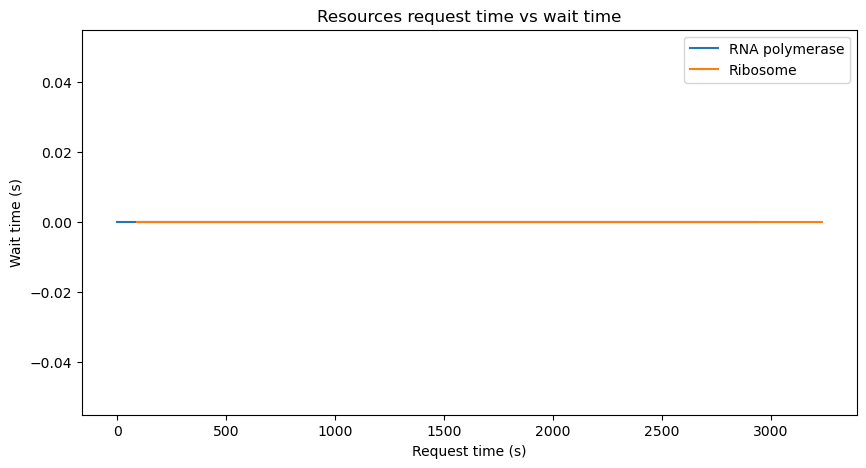

In [ ]:
resources_request_wait_time(rna_polymerase_df, ribosome_df)

### Transfer RNA

In [ ]:
plot_codons_request(file_path='results/test/rna_transfer/', time_unit=1)